In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import pickle

In [2]:
df=pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [4]:
label_encoder_gender=LabelEncoder()
df['Gender']=label_encoder_gender.fit_transform(df['Gender'])

In [7]:
onehot_encoder_geo=OneHotEncoder(handle_unknown='ignore')
geo_encoded=onehot_encoder_geo.fit_transform(df[['Geography']]).toarray()
geo_encoded_df=pd.DataFrame(geo_encoded,columns=onehot_encoder_geo.get_feature_names_out(['Geography']))

In [8]:
geo_encoded_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [9]:
df=pd.concat([df.drop('Geography',axis=1),geo_encoded_df],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [10]:
x=df.drop('EstimatedSalary',axis=1)
y=df['EstimatedSalary']

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [13]:
with open('label_encoder_gender2.pkl','wb') as f:
    pickle.dump(label_encoder_gender,f)

with open('onehot_encoder_geo2.pkl','wb') as f:
    pickle.dump(onehot_encoder_geo,f)

with open('scaler2.pkl','wb') as f:
    pickle.dump(scaler,f)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [15]:
model=Sequential([
    Dense(64,activation='relu',input_shape=(x_train.shape[1],)),
    Dense(32,activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

In [17]:
log_dir='regressionlogs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callbacks=TensorBoard(log_dir=log_dir,histogram_freq=1)

In [18]:
early_stop_callback=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [19]:
history=model.fit(x_train,y_train,
                  epochs=100,
                  validation_data=(x_test,y_test),
                  callbacks=[early_stop_callback,tensorboard_callbacks]
                  )

Epoch 1/100


250/250 [==============================] - 2s 4ms/step - loss: 13384933376.0000 - mae: 100384.4453 - val_loss: 13011094528.0000 - val_mae: 98538.8828
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 13247669248.0000 - mae: 99708.1875 - val_loss: 12737679360.0000 - val_mae: 97156.8984
Epoch 3/100
250/250 [==============================] - 1s 2ms/step - loss: 12757960704.0000 - mae: 97270.8516 - val_loss: 12028623872.0000 - val_mae: 93573.5703
Epoch 4/100
250/250 [==============================] - 1s 2ms/step - loss: 11781633024.0000 - mae: 92415.0000 - val_loss: 10828471296.0000 - val_mae: 87508.6562
Epoch 5/100
250/250 [==============================] - 1s 2ms/step - loss: 10331633664.0000 - mae: 85256.7812 - val_loss: 9232035840.0000 - val_mae: 79438.7578
Epoch 6/100
250/250 [==============================] - 1s 2ms/step - loss: 8581482496.0000 - mae: 76467.1328 - val_loss: 7474728960.0000 - val_mae: 70677.2109
Epoch 7/100
250/250 [=============

In [20]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir regressionlogs/fit

Reusing TensorBoard on port 6006 (pid 9120), started 0:00:11 ago. (Use '!kill 9120' to kill it.)

In [23]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 0s 1ms/step - loss: 3356162816.0000 - mae: 50136.9766


[3356162816.0, 50136.9765625]

In [24]:
model.save('regressionmodel.h5')

c:\Users\farde\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

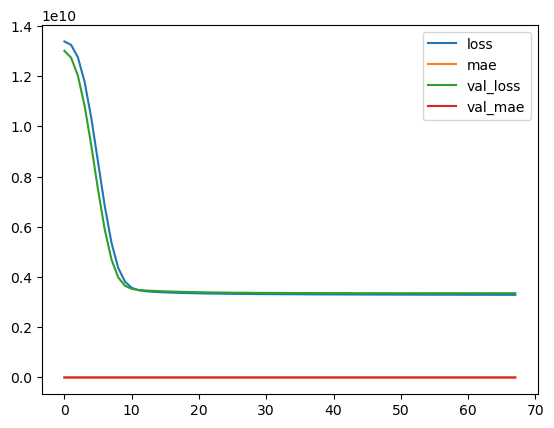

In [28]:
pd.DataFrame(history.history).plot()